In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style="whitegrid")

In [29]:
# Read the CSV file
df = pd.read_csv('../data/merged_data.csv')

In [30]:
df.head()

,time,pv_output_kw,irradiance_direct,irradiance_diffuse,temperature_pv,hour,month,season,temperature_wx,humidity,wind_speed,wind_direction,mean_sea_level_pressure,cloudiness
0,2019-01-01 00:00:00+00:00,0.0,0.0,0.0,0.912,0,1,Winter,0.68,98.90,1.38,268.3,95.88,0.5029
1,2019-01-01 01:00:00+00:00,0.0,0.0,0.0,0.864,1,1,Winter,0.64,98.94,1.36,262.4,95.87,0.6432
2,2019-01-01 02:00:00+00:00,0.0,0.0,0.0,0.833,2,1,Winter,0.64,98.91,1.42,254.5,95.84,1.0000
3,2019-01-01 03:00:00+00:00,0.0,0.0,0.0,0.793,3,1,Winter,0.64,98.84,1.45,249.4,95.78,1.0000
4,2019-01-01 04:00:00+00:00,0.0,0.0,0.0,0.630,4,1,Winter,0.50,98.56,1.47,246.4,95.70,1.0000


In [31]:
df.shape

(8760, 14)

In [32]:
# Assuming df is already loaded and has 'datetime' as a column
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values("time")

/var/folders/wn/5hltvcvs3qg_bl9q2vw70c9r0000gn/T/ipykernel_84042/739120807.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x="hour", y="pv_output_kw", estimator="mean", ci="sd")


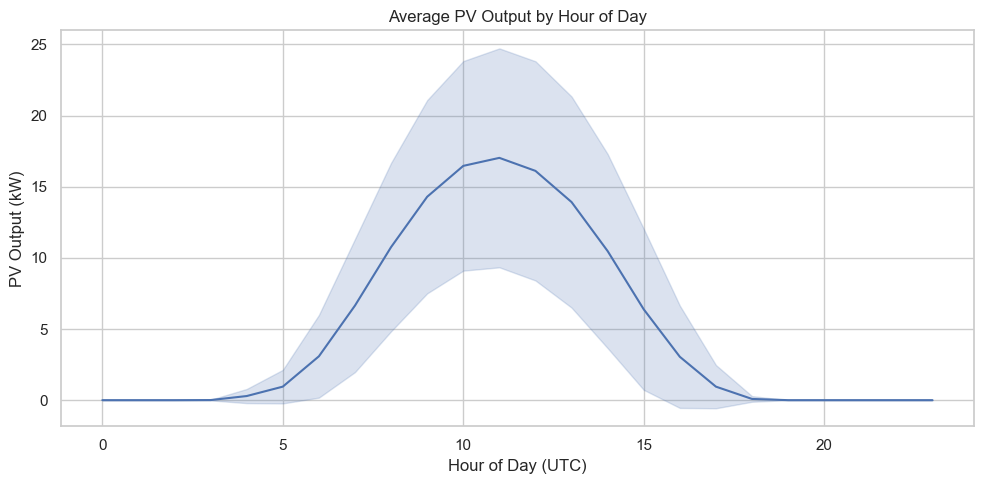

In [33]:
# 1. PV Output by Hour of Day (with mean and SD)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="hour", y="pv_output_kw", estimator="mean", ci="sd")
plt.title("Average PV Output by Hour of Day")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("PV Output (kW)")
plt.tight_layout()
plt.show()

A classic bell curve centered around mid-day (roughly 11:00–13:00 UTC). Most PV output occurs between 9:00 and 16:00 UTC, peaking at noon — typical of solar generation patterns. There’s high standard deviation during peak hours, suggesting fluctuations due to weather (e.g., cloudiness).

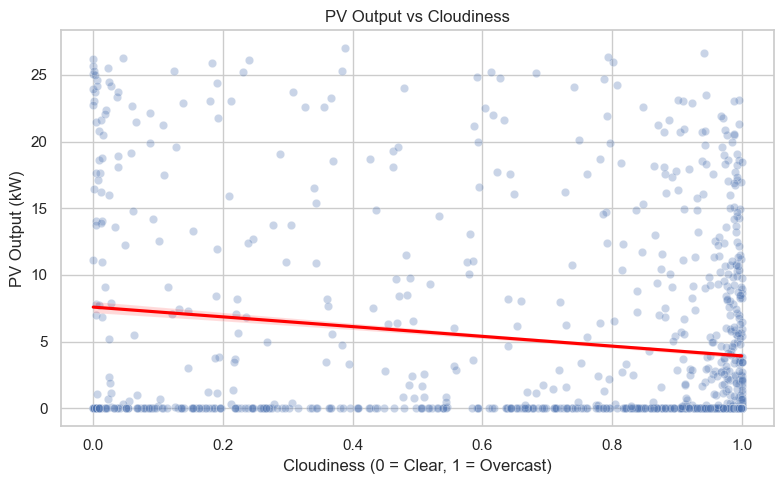

In [34]:
# 2. PV Output vs Cloudiness
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df.sample(1000), x="cloudiness", y="pv_output_kw", alpha=0.3)
sns.regplot(data=df, x="cloudiness", y="pv_output_kw", scatter=False, color="red")
plt.title("PV Output vs Cloudiness")
plt.xlabel("Cloudiness (0 = Clear, 1 = Overcast)")
plt.ylabel("PV Output (kW)")
plt.tight_layout()
plt.show()

Strong negative correlation — as cloudiness increases, PV output drops. Very low PV values when cloudiness > 0.8, confirming the system is cloud-sensitive. Most cloudiness values are near 1.0 (overcast), which likely suppresses generation.

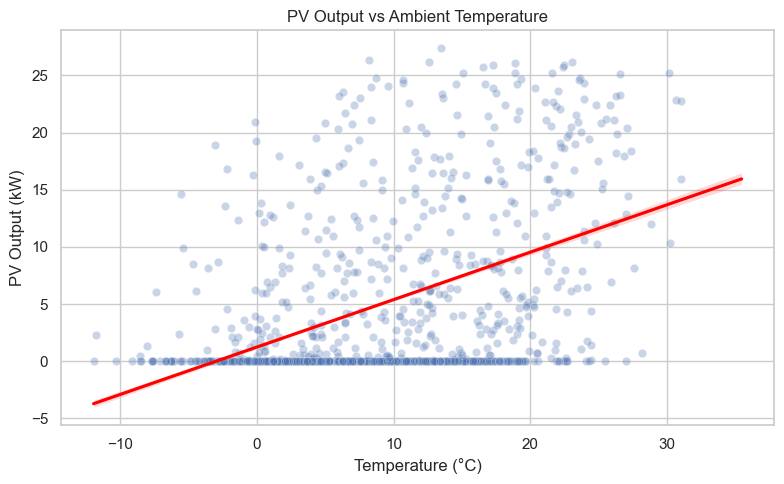

In [35]:
# 3. PV Output vs Ambient Temperature
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df.sample(1000), x="temperature_wx", y="pv_output_kw", alpha=0.3)
sns.regplot(data=df, x="temperature_wx", y="pv_output_kw", scatter=False, color="red")
plt.title("PV Output vs Ambient Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("PV Output (kW)")
plt.tight_layout()
plt.show()

Weak-to-moderate positive correlation — higher temperatures slightly boost output. The relationship is not very strong — temperature plays a secondary role compared to irradiance/cloudiness. Output tends to plateau or even decline beyond ~30°C, which is expected due to PV panel efficiency losses.

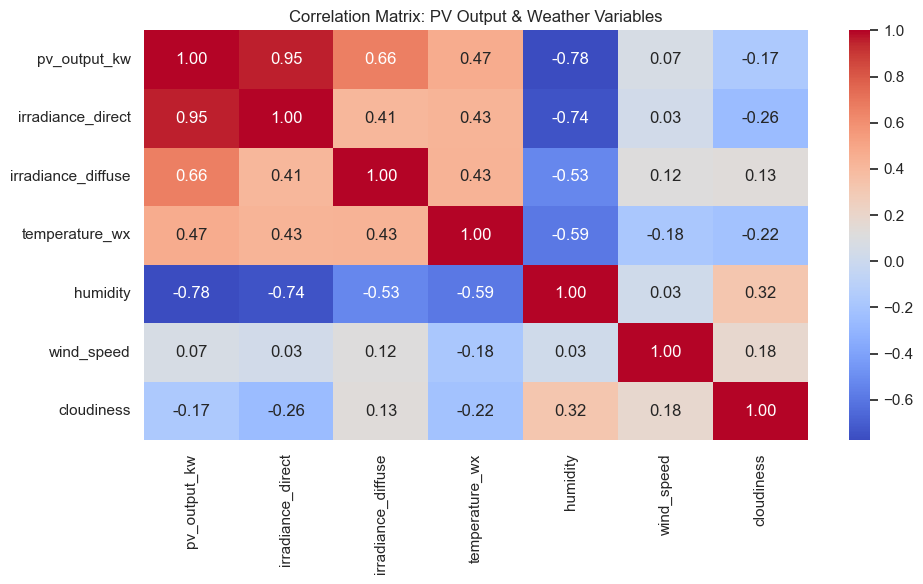

In [36]:
# 4. Correlation Heatmap
plt.figure(figsize=(10, 6))
corr = df[[
    "pv_output_kw", "irradiance_direct", "irradiance_diffuse",
    "temperature_wx", "humidity", "wind_speed", "cloudiness"
]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: PV Output & Weather Variables")
plt.tight_layout()
plt.show()

/var/folders/wn/5hltvcvs3qg_bl9q2vw70c9r0000gn/T/ipykernel_84042/3626506935.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="hour", y="pv_output_kw", hue="season", estimator="mean", ci=None)


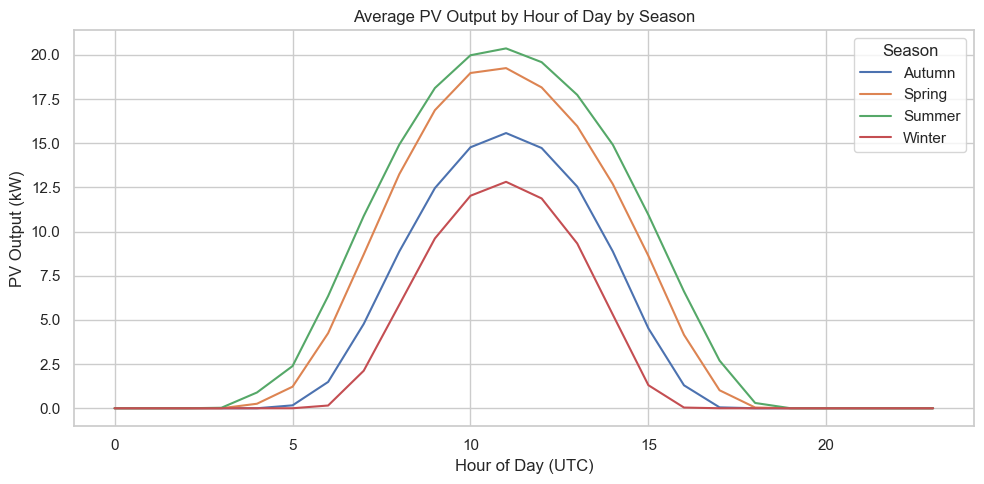

In [37]:
df["hour"] = df["time"].dt.hour
df["month"] = df["time"].dt.month
df["season"] = df["month"] % 12 // 3 + 1
df["season"] = df["season"].map({1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"})
df["season"] = df["season"].astype("category")

# Plot: PV Output by Hour grouped by Season
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="hour", y="pv_output_kw", hue="season", estimator="mean", ci=None)
plt.title("Average PV Output by Hour of Day by Season")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("PV Output (kW)")
plt.legend(title="Season")
plt.tight_layout()
plt.show()

/var/folders/wn/5hltvcvs3qg_bl9q2vw70c9r0000gn/T/ipykernel_84042/528332541.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="cloudiness_bin", y="pv_output_kw", palette="Blues")


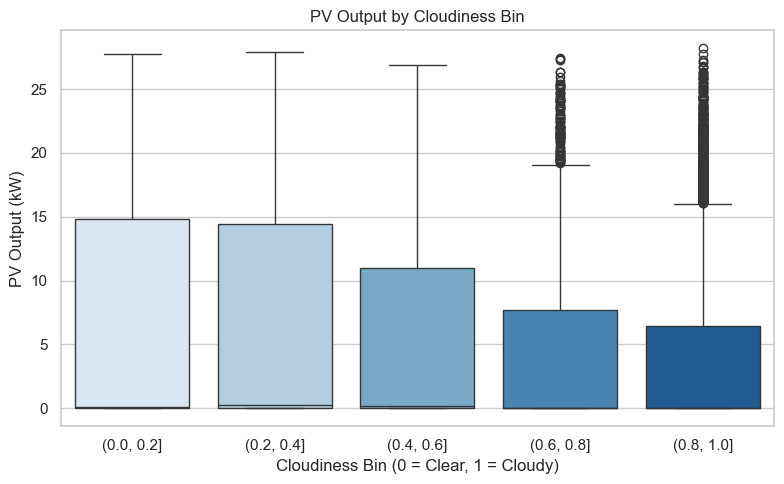

In [38]:
# Bin cloudiness from 0 to 1 into 5 groups
df["cloudiness_bin"] = pd.cut(df["cloudiness"], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="cloudiness_bin", y="pv_output_kw", palette="Blues")
plt.title("PV Output by Cloudiness Bin")
plt.xlabel("Cloudiness Bin (0 = Clear, 1 = Cloudy)")
plt.ylabel("PV Output (kW)")
plt.tight_layout()
plt.show()

/var/folders/wn/5hltvcvs3qg_bl9q2vw70c9r0000gn/T/ipykernel_84042/180753163.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="temperature_bin", y="pv_output_kw", palette="Oranges")


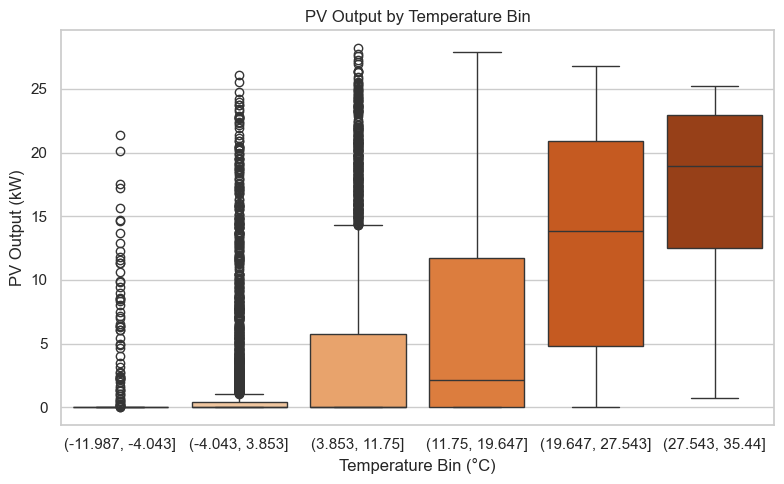

In [39]:
# Bin temperature into 6 equal-width bins
df["temperature_bin"] = pd.cut(df["temperature_wx"], bins=6)

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="temperature_bin", y="pv_output_kw", palette="Oranges")
plt.title("PV Output by Temperature Bin")
plt.xlabel("Temperature Bin (°C)")
plt.ylabel("PV Output (kW)")
plt.tight_layout()
plt.show()